# Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from datetime import datetime, timedelta
from tabulate import tabulate

# Loading the Data

In [2]:
data = pd.read_csv('combined_dataset.csv')
target_data = data[["Date", "TATAMOTORS_Close", "M&M_Close"]]
target_data['Date'] = pd.to_datetime(target_data['Date'])
data.head()

C:\Users\omkar\AppData\Local\Temp\ipykernel_3776\1977553933.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  target_data['Date'] = pd.to_datetime(target_data['Date'])
C:\Users\omkar\AppData\Local\Temp\ipykernel_3776\1977553933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data['Date'] = pd.to_datetime(target_data['Date'])


,Date,TATAMOTORS_Open,TATAMOTORS_High,TATAMOTORS_Low,TATAMOTORS_Close,M&M_Open,M&M_High,M&M_Low,M&M_Close
0,31-01-2019,175.800003,183.899994,175.800003,181.199997,678.000000,683.000000,672.750000,680.049988
1,01-02-2019,182.000000,185.899994,179.550003,181.649994,689.000000,715.400024,680.549988,688.400024
2,04-02-2019,181.000000,183.699997,178.199997,180.250000,688.000000,688.400024,670.349976,674.450012
3,05-02-2019,180.699997,181.149994,174.699997,175.800003,675.250000,692.599976,672.650024,684.900024
4,06-02-2019,176.000000,179.449997,171.899994,178.500000,687.900024,698.250000,682.049988,695.099976


In [3]:
target_data.head()


,Date,TATAMOTORS_Close,M&M_Close
0,2019-01-31,181.199997,680.049988
1,2019-02-01,181.649994,688.400024
2,2019-02-04,180.250000,674.450012
3,2019-02-05,175.800003,684.900024
4,2019-02-06,178.500000,695.099976


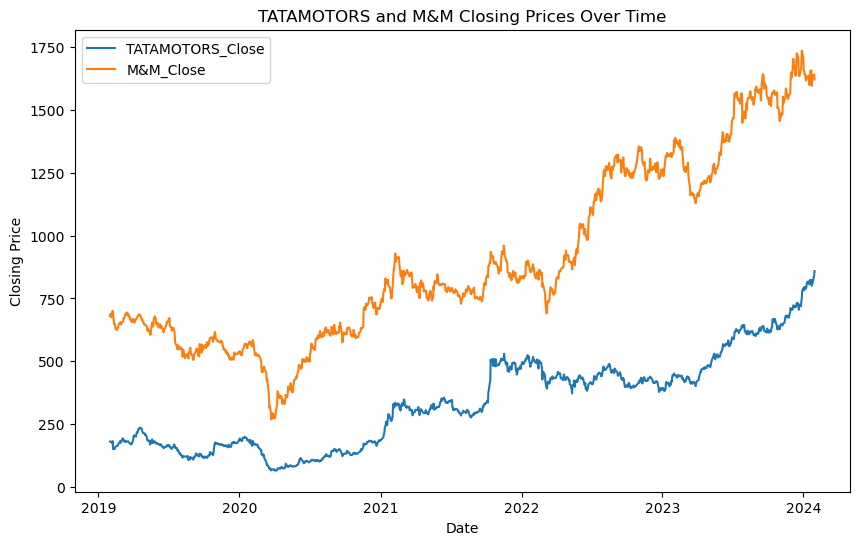

In [4]:
plt.figure(figsize=(10, 6))

plt.plot(target_data['Date'], target_data['TATAMOTORS_Close'], label='TATAMOTORS_Close')
plt.plot(target_data['Date'], target_data['M&M_Close'], label='M&M_Close')

plt.title('TATAMOTORS and M&M Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


# Data Preprocessing

In [5]:
# Check for NaN values
nan_rows = target_data[target_data.isna().any(axis=1)]
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
Empty DataFrame
Columns: [Date, TATAMOTORS_Close, M&M_Close]
Index: []


In [6]:
# Drop NaN values
target_data = target_data.dropna()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target_data[['TATAMOTORS_Close', 'M&M_Close']])
scaled_data

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Splitting the data into training and testing

In [7]:
# Split data
training_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

# Verify the split
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (987, 2)
Testing Data Shape: (247, 2)


# Create dataset

In [8]:
def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, :])
    return np.array(X), np.array(y)


In [9]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [10]:
# Verify shapes
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (886, 100, 2)
y_train Shape: (886, 2)
X_test Shape: (146, 100, 2)
y_test Shape: (146, 2)


# Build the Model

In [11]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(100, 2)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(2))

model.summary()


C:\Users\omkar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 60)             │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          22,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,622 (225.09 KB)

 Trainable params: 57,622 (225.09 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)


In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 0.0618 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0061 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 260ms/step - loss: 0.0040 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - loss: 0.0037 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 0.0032 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.0031 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0025 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0028 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 0.0026 - val_loss: 0.0073 - learning_rate: 0.0010

# Generating Predictions

In [14]:
# Function to generate future predictions
def generate_future_predictions(start_date, days=30):
    start_date = pd.to_datetime(start_date)
    last_100_days = scaled_data[-100:]
    predictions = []

    for _ in range(days):
        X_input = last_100_days[-100:].reshape(1, 100, 2)
        pred = model.predict(X_input)
        predictions.append(pred[0])
        last_100_days = np.append(last_100_days, [pred[0]], axis=0)

    predictions = scaler.inverse_transform(predictions)
    prediction_dates = [start_date + timedelta(days=i) for i in range(days)]
    #print(f"Date: {prediction_dates.strftime('%Y-%m-%d')}, Tata Motors: {predictions[i][0]:.2f}, M&M: {predictions[i][1]:.2f}")
    return prediction_dates, predictions

# User input for start date
start_date = input("Enter the start date (YYYY/MM/DD): ")
prediction_dates, predictions = generate_future_predictions(start_date, 30)


Enter the start date (YYYY/MM/DD):  2024/01/02


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 

# Evaluation Metrics

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return rmse, mse, mae, r2

# Inverse transform test data
y_test_inv = scaler.inverse_transform(y_test)
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

# Calculate metrics for TATAMOTORS and M&M
tata_metrics = calculate_metrics(y_test_inv[:, 0], test_predict[:, 0])
mm_metrics = calculate_metrics(y_test_inv[:, 1], test_predict[:, 1])

# Create a table for metrics
metrics_table = [
    ["TATAMOTORS", tata_metrics[0], tata_metrics[1], tata_metrics[2], tata_metrics[3]],
    ["M&M", mm_metrics[0], mm_metrics[1], mm_metrics[2], mm_metrics[3]]
]

# Print the table
print(tabulate(metrics_table, headers=["Stock", "RMSE", "MSE", "MAE", "R²"], tablefmt="pretty"))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
+------------+-------------------+-------------------+--------------------+----------------------+
|   Stock    |       RMSE        |        MSE        |        MAE         |          R²          |
+------------+-------------------+-------------------+--------------------+----------------------+
| TATAMOTORS | 45.9524149100601  | 2111.624436066314 | 34.553227243444994 |  0.5448716575867403  |
|    M&M     | 69.56174664313754 | 4838.836596044056 | 56.41871119750644  | -0.06522943213349164 |
+------------+-------------------+-------------------+--------------------+----------------------+


# Graphical Visualization

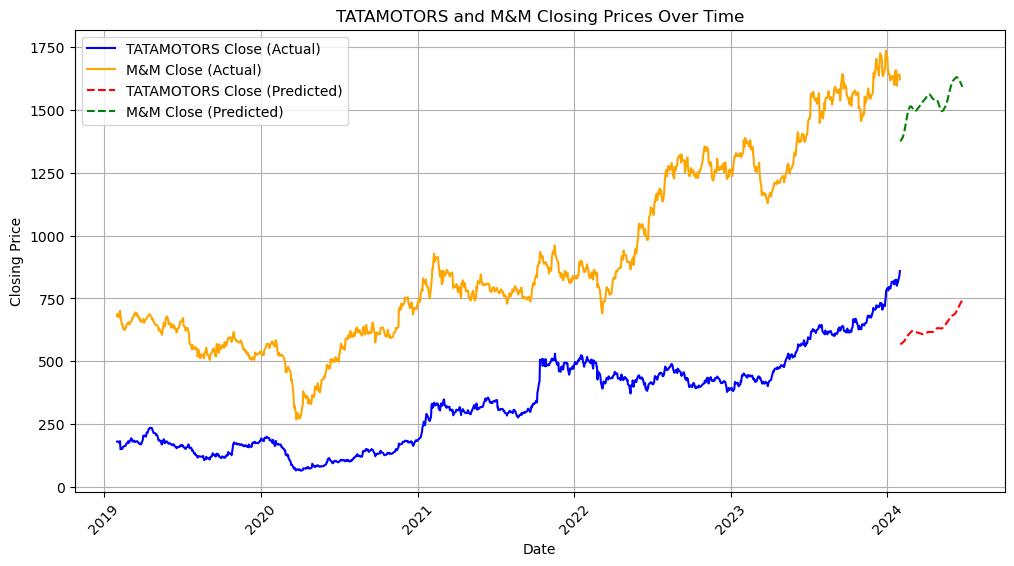

In [16]:
plt.figure(figsize=(12, 6))

# Plot graph
dates = target_data['Date']
TATAMOTORS_Close = target_data['TATAMOTORS_Close']
mm_Close = target_data['M&M_Close']

# Plot Actual Prices
plt.plot(dates, TATAMOTORS_Close, label='TATAMOTORS Close (Actual)', color='blue')
plt.plot(dates, mm_Close, label='M&M Close (Actual)', color='orange')

# Future Dates for Predicted Prices
future_dates = [dates.iloc[-1] + timedelta(days=i+1) for i in range(len(test_predict))]

# Plot Predicted Prices
plt.plot(future_dates, test_predict[:, 0], label='TATAMOTORS Close (Predicted)', color='red', linestyle='--')
plt.plot(future_dates, test_predict[:, 1], label='M&M Close (Predicted)', color='green', linestyle='--')

# Enhance Plot
plt.title('TATAMOTORS and M&M Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


# Investment suggestion

In [17]:
def investment_suggestion(tata_metrics, mm_metrics):
    if tata_metrics[3] > mm_metrics[3]:
        return "Invest in TATAMOTORS as it has a higher R² value, indicating better prediction accuracy."
    else:
        return "Invest in M&M as it has a higher R² value, indicating better prediction accuracy."

print(investment_suggestion(tata_metrics, mm_metrics))


Invest in TATAMOTORS as it has a higher R² value, indicating better prediction accuracy.


In [17]:
! pip install keras-tuner

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # LSTM Layer 1
    model.add(LSTM(
        units=hp.Choice('units_layer1', [50, 100, 150]),
        return_sequences=True,
        input_shape=(100, 2)
    ))
    model.add(Dropout(hp.Choice('dropout_rate1', [0.2, 0.3, 0.5])))
    
    # LSTM Layer 2
    model.add(LSTM(
        units=hp.Choice('units_layer2', [50, 100]),
        return_sequences=False
    ))
    model.add(Dropout(hp.Choice('dropout_rate2', [0.2, 0.3, 0.5])))
    
    # Output Layer
    model.add(Dense(2, activation='linear'))
    
    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1])),
        loss='mean_squared_error'
    )
    return model

# Instantiate the Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_logs',
    project_name='stock_price_prediction'
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:", best_hp.values)

# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=best_hp['batch_size'])

# Evaluate the best model
loss = best_model.evaluate(X_test, y_test)
print(f"Best Model Loss: {loss}")

tuner.results_summary()
tuner.search_space_summary()
tuner.get_best_models(num_models=1)


Trial 1 Complete [00h 06m 29s]
val_loss: 0.0024766515707597136

Best val_loss So Far: 0.0024766515707597136
Total elapsed time: 00h 06m 29s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
150               |50                |units_layer1
0.2               |0.3               |dropout_rate1
100               |100               |units_layer2
0.5               |0.3               |dropout_rate2
0.001             |0.001             |learning_rate

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 981ms/step - loss: 0.0287 - val_loss: 0.0609
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 836ms/step - loss: 0.0053 - val_loss: 0.0338
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 966ms/step - loss: 0.0038 - val_loss: 0.0174
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - loss: 0.0029 - val_loss: 0.0146
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.0025 - val_loss: 0.0118
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - loss: 0.0024 - val_loss: 0.0028
Epo

KeyboardInterrupt: 